# WATER BAG CLASSIFICATION - IMBALANCE AND CALIBRATION
### BASED ON INMET METHEOROLOGICAL STATIONS DATA

---
## Define Functions

#### Change project root directory

In [1]:
cd ../

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\ACELERAÇÃO


#### Import modules and libraries

In [2]:
import os, json, pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

#### Time serie features transformation pipeline & binary classification pipeline (Authoral)
from Modulos.sample_filter import min_max_filter_stats, min_max_filter
from Modulos.timeserie_transform import TimeseriesTransformPipeline
from Modulos.imbalanced_selection import groupConsecutiveFlags, MinorityGroupSplitUndersample
from Modulos.imbalanced_classification import ClassificationPipeline, classesGroupRecall

#### Preprocessing & machine learning modules
from sklearn.preprocessing import MinMaxScaler as mms
from Modulos.cv_samplers import GroupUnderSampleSplit, print_cls_cnt
from sklearn.utils import all_estimators
from sklearn.metrics import classification_report as cr
from imblearn import ensemble

#  Classifier colleciton
classifiers = dict(all_estimators('classifier'))

# Select specific classification models
gbc = classifiers['GradientBoostingClassifier']
brfc = ensemble.BalancedRandomForestClassifier

#### Define metrics and scoring functions
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, recall_score, precision_score

recall_0 = make_scorer(recall_score, pos_label=0)
recall_1 = make_scorer(recall_score, pos_label=1)
precision_0 = make_scorer(precision_score, pos_label=0)
precision_1 = make_scorer(precision_score, pos_label=1)

scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall', 'precision': 'precision',
    'recall-0': recall_0, 'recall-1': recall_1,
    'precision-0': precision_0, 'precision-1': precision_1
}

c:\Users\luisr\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


---
## Load & Preprocess Data

In [3]:
from Modulos.waterbags import waterbag_project

project = waterbag_project(time_serie='clusters', freq='upsample', load_waterbags=True)

data = project.data
group_ts = project.time_serie
waterbags = project.waterbags

# Drop records before july, 2018 to reduce imbalance
data = data['2018-06':]
group_ts = group_ts['2018-06':]

# Sample groups names per group label
routes = waterbags.groupby(['sublabel', 'main_route']).first().index.to_frame().set_index('sublabel').to_dict()['main_route']

---

# Preprocessing and Data Transformation

### Feature dataset and target variables

In [4]:
top_grp = '1'

X = TimeseriesTransformPipeline(
    data, cut=-1,
    drop_empty_cols=True, scale=True,
    interpolate=None, fillna=None
)

Xf = TimeseriesTransformPipeline(
    X, interpolate='nearest', fillna='min'
)

### Select example water bag group
Y = group_ts[str(top_grp)].loc[X.index].copy()

groups = groupConsecutiveFlags(ts=Y)

cnts = [Y.value_counts(norm).to_frame('Class Count') for norm in (False, True)]
print(f'Water bag group: {routes[int(top_grp)]}. (id: {top_grp})')
print(); display(pd.concat(cnts, 1))

Initial data: (142867, 230)
Drop empty columns:  (142866, 217)
Initial data: (142866, 217)
Water bag group: Rua do Catete. (id: 1)



,Class Count,Class Count
0.0,142083,0.994519
1.0,783,0.005481


### Target Transformation

In [5]:
periods_ahead = 2
Y = (Y.rolling(periods_ahead, closed='left', min_periods=1).sum().shift(- periods_ahead + 1) > 0).astype('float')

cnts = [Y.value_counts(norm).to_frame('Class Count') for norm in (False, True)]
print('Train folder'); display(pd.concat(cnts, 1))

Train folder


,Class Count,Class Count
0.0,142011,0.994015
1.0,855,0.005985


### Validation folder

In [6]:
train_end, eval_start, eval_end = '2021-10', '2021-11', '2022-04'

# Validataion fraction
X_eval = Xf[eval_start: eval_end]
X = X[:train_end]
Xf = Xf[:train_end]

Y_eval = Y.loc[X_eval.index]
Y = Y.loc[X.index]

groups_eval = groups.loc[X_eval.index]
groups = groups.loc[X.index]

cnts = [Y.value_counts(norm).to_frame('Class Count') for norm in (False, True)]
print('Train folder'); display(pd.concat(cnts, 1))

cnts = [Y_eval.value_counts(norm).to_frame('Class Count') for norm in (False, True)]
print('Validation folder'); display(pd.concat(cnts, 1))

Train folder


,Class Count,Class Count
0.0,119156,0.993762
1.0,748,0.006238


Validation folder


,Class Count,Class Count
0.0,17269,0.993842
1.0,107,0.006158


### Validation statistics

In [7]:
eval_size = len(Y_eval) / len(Y) * 100
eval_minority = (Y_eval==1).sum() / (Y==1).sum() * 100
eval_stats = pd.DataFrame(
    [eval_size, eval_minority],
    ['Samples', 'Positive Samples'],
    ['Validation (%)'],
).round(2)
display(eval_stats)

,Validation (%)
Samples,14.49
Positive Samples,14.30


### Data leaking

In [8]:
Y.tail(3).index

DatetimeIndex(['2021-10-31 23:15:00', '2021-10-31 23:30:00',
               '2021-10-31 23:45:00'],
              dtype='datetime64[ns]', freq=None)

In [9]:
Y_eval.head(3).index

DatetimeIndex(['2021-11-01 00:00:00', '2021-11-01 00:15:00',
               '2021-11-01 00:30:00'],
              dtype='datetime64[ns]', freq=None)

---
# Filter hour records by variables threshold

### Records left after filtering by columns' minimum thresholds

In [10]:
#### Extract minority and majority classes records
mino, majo = X[Y==1], X[~(Y==1)]
mino_desc = mino.describe()

#### Filter records by minority minimum values
stats, cum_stats = min_max_filter_stats(X, mino_desc, stat='min', acumulate='and', top_down=True)
stats_max, cum_stats_max = min_max_filter_stats(X, mino_desc, stat='max', acumulate='and', top_down=True)

#### Records above and below target minimum and maximum per column

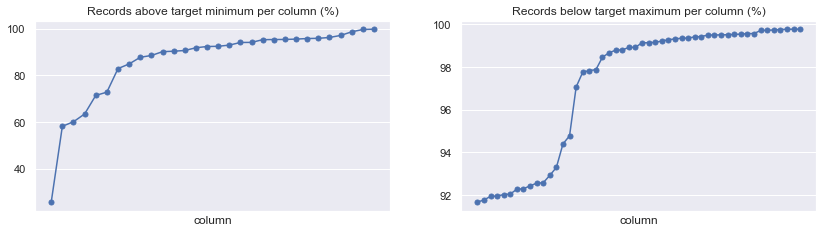

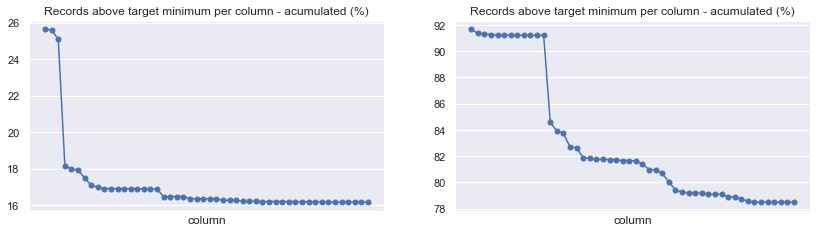

In [11]:
n_cum = 50

fig, ax = plt.subplots(1, 2, figsize=(14, 3.5))
stats.set_index('column')['rows left (%)'].head(30).plot(marker='o', ms=5, xticks=[], title='Records above target minimum per column (%)', ax=ax[0])
stats_max.set_index('column')['rows left (%)'].head(50).plot(marker='o', ms=5, xticks=[], title='Records below target maximum per column (%)', ax=ax[1])

fig, ax = plt.subplots(1, 2, figsize=(14, 3.5))
cum_stats.set_index('column')['rows left cum (%)'].iloc[:n_cum].plot(xticks=[], marker='o', ms=5, title='Records above target minimum per column - acumulated (%)', ax=ax[0])
cum_stats_max.set_index('column')['rows left cum (%)'].iloc[:n_cum].plot(xticks=[], marker='o', ms=5, title='Records above target minimum per column - acumulated (%)', ax=ax[1])
plt.show()

### Filter records

In [12]:
n_filters = 4

min_values = mino_desc.loc['min'].loc[stats['column']]
max_values = mino_desc.loc['max'].loc[stats_max['column']]

# Filter data by positive class minimum values
X_filt = min_max_filter(
    X, min_values, # max_values,
    n_filters=n_filters, margin_min=0.0, margin_max=0.0
)

# Filter data by positive class maximum values
# X_filt = min_max_filter(
#     X_filt, None, max_values,
#     n_filters=n_filters, margin_min=0.0, margin_max=0.0
# )

### Filtered transformed data
X_filt = Xf.loc[X_filt.index]
# X_filt = TimeseriesTransformPipeline(
#     X_filt, interpolate='nearest', fillna='min'
# )

### Filter target variable
Y_filt = Y.loc[X_filt.index]

# groups_filt = groupConsecutiveFlags(ts=Y_filt)
groups_filt = groups.loc[X_filt.index] # Does the same as above

cnts = [
    Y_filt.value_counts().to_frame('Class Count'),
    100 * (Y_filt.value_counts().to_frame('Percent left (%)') / Y.value_counts().to_frame('Percent left (%)')).round(4)
]
display(pd.concat(cnts, 1))


Records: 119904
Records left: 21771
Records left (%): 18.16 %



,Class Count,Percent left (%)
0.0,21023,17.64
1.0,748,100.00


---
# Cross validate filtered records

In [13]:
# Main parameters definition
seed = 0

n_splits = 5
train_size = 0.66
test_size = 0.33
train_prct = None
test_prct = None

# Model definition
model = gbc(n_estimators=100, random_state=seed)

### Base KFold Cross Validation on all samples

In [14]:
splitter = MinorityGroupSplitUndersample(
    n_splits,
    train_size, test_size, # Not used if minority split strategy is GroupKFold
    train_prct, test_prct,
    random_state=seed,
)

cv_base = list(splitter.split(
    Xf, Y, groups,
    strategy='GroupKFold'
)); print_cls_cnt(Y, cv_base[0][0], cv_base[0][1])

,Train set,Test set
Class,,
0.0,95101,24055
1.0,597,151


#### Split evaluation

In [65]:
group_shuffle_scr = pd.DataFrame(cross_validate(
    model, Xf, Y, cv=cv_base,
    scoring=scoring, n_jobs=3,
    verbose=5, error_score='raise'
))

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   5 | elapsed:  4.6min remaining:  6.9min
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  8.4min finished


#### Save and reload baseline score

In [15]:
# group_shuffle_scr.to_csv('Modelagem de Bolsões/Scores/Baseline_30Min_KFold_5.csv', index=True)

group_shuffle_scr = pd.read_csv('Modelagem de Bolsões/Scores/Baseline_30Min_KFold_5.csv', index_col=0)

### Internal cross validation - Fit and score inside filtered samples

In [16]:
splitter = MinorityGroupSplitUndersample(
    n_splits,
    train_size, test_size, # Not used if minority split strategy is GroupKFold
    train_prct, test_prct,
    random_state=seed,
)

cv_filt = list(splitter.split(
    X_filt, Y_filt, groups_filt,
    strategy='GroupKFold'
)); print_cls_cnt(Y_filt, cv_filt[0][0], cv_filt[0][1])

,Train set,Test set
Class,,
0.0,16779,4244
1.0,597,151


#### Split evaluation

In [18]:
scr_filt = pd.DataFrame(cross_validate(
    model,
    X_filt, Y_filt,
    cv=cv_filt, scoring=scoring,
    return_train_score=True,
    n_jobs=-1, verbose=5,
))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


### Filtered train set + True proportion test set

In [19]:
from imblearn.under_sampling import RandomUnderSampler

y_cnt = Y.value_counts()
sampling_strategy = y_cnt[1] / y_cnt[0]
rus = RandomUnderSampler(sampling_strategy, random_state=seed)

X_index = np.array(range(X.shape[0]))
out_index = X_index[~X.index.isin(X_filt.index)].tolist() # filtered out records index, only contains negative class samples

# Reuse group shuffle split and include left out negative class test samples 
cv_plus = []
for t_idx, e_idx in cv_filt:
    t_idx_x,  e_idx_x = (X_index[X.index.isin(X_filt.iloc[idx].index)].tolist() for idx in [t_idx, e_idx]) # Convert X_filt positional index to X positional index
    left_test = e_idx_x + out_index
    x_test, y_test = Xf.iloc[left_test], Y.iloc[left_test]
    x_under, y_under = rus.fit_resample(x_test, y_test)
    y_under.index = y_test.index[rus.sample_indices_]
    left_under = X_index[X.index.isin(y_under.index)].tolist()
    cv_plus.append((t_idx_x, left_under)) 
print_cls_cnt(Y, cv_plus[0][0], cv_plus[0][1])

c:\Users\luisr\anaconda3\lib\site-packages\imblearn\utils\_validation.py:587: FutureWarning: Pass sampling_strategy=0.006277484977676323 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


,Train set,Test set
Class,,
0.0,16779,24054
1.0,597,151


### Fit inside filtered records and score for included and excluded samples prediction

In [21]:
scr_out = pd.DataFrame(cross_validate(
    model, Xf, Y, cv=cv_plus,
    scoring=scoring, n_jobs=-1,
    verbose=5, error_score='raise'
))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


### Fill excluded samples prediction

In [20]:
scrs = []
for i, (t_ind, e_ind) in enumerate(cv_plus):
    co(wait=True); print(f'{i+1}/{len(cv_plus)} splits scored')
    xt, xe, yt, ye = Xf.iloc[t_ind], Xf.iloc[e_ind], Y.iloc[t_ind], Y.iloc[e_ind]
    model.fit(xt, yt)
    yhat = model.predict(xe)
    # Fill prediction of outsider group 
    filt_out = pd.Series(e_ind, dtype='int').isin(out_index).values
    yhat[filt_out] = 0.0  # Fix prediction for data left out of the filter
    scr = pd.DataFrame(cr(ye, yhat, output_dict=True)).T
    scr = pd.concat([scr.loc[['0.0', '1.0', 'macro avg'], 'recall'], scr.loc[['0.0', '1.0', 'macro avg'], 'precision']])
    scr.index = ['recall 0', 'recall 1', 'recall', 'precision 0', 'precision 1',  'precision']
    scrs.append(scr)
scr_fill = pd.concat(scrs, 1).T

5/5 splits scored


---
# Visualize cross validation results

### Score statistical description comparison

In [27]:
desc_base = group_shuffle_scr.describe().loc[['mean', 'min', 'max', 'std'], ['test_recall-0', 'test_recall-1', 'test_precision-1']]
desc_filt = scr_filt.describe().loc[['mean', 'min', 'max', 'std'], ['test_recall-0', 'test_recall-1', 'test_precision-1']]
desc_out = scr_out.describe().loc[['mean', 'min', 'max', 'std'], ['test_recall-0', 'test_recall-1', 'test_precision-1']]
desc_fill = scr_fill.describe().loc[['mean', 'min', 'max', 'std'], ['recall 0', 'recall 1', 'precision 1']]

titles = [
    'Base line - true proportion',
    'Filtered - internal proportion',
    'Filtered - true proportion',
    'Filtered fixed predictions - true proportion'
]

descs = [desc_base, desc_filt, desc_out, desc_fill]

for title, desc in zip(titles, descs):
    print('\n', title, '\n')
    display(pd.concat([desc]))


 Base line - true proportion 



,test_recall-0,test_recall-1,test_precision-1
mean,0.999211,0.400636,0.751845
min,0.998912,0.218543,0.687500
max,0.999376,0.506757,0.833333
std,0.000191,0.130872,0.057589



 Filtered - internal proportion 



,test_recall-0,test_recall-1,test_precision-1
mean,0.997240,0.509656,0.866785
min,0.996466,0.298013,0.848101
max,0.998351,0.628378,0.885714
std,0.000684,0.138057,0.013780



 Filtered - true proportion 



,test_recall-0,test_recall-1,test_precision-1
mean,0.999715,0.511007,0.921346
min,0.999540,0.298013,0.881720
max,0.999875,0.635135,0.943662
std,0.000148,0.139535,0.027310



 Filtered fixed predictions - true proportion 



,recall 0,recall 1,precision 1
mean,0.999840,0.511007,0.952318
min,0.999749,0.298013,0.931818
max,0.999917,0.635135,0.979167
std,0.000076,0.139535,0.017680


### Score distribution comparison for baseline vs predicted vs filled excluded samples

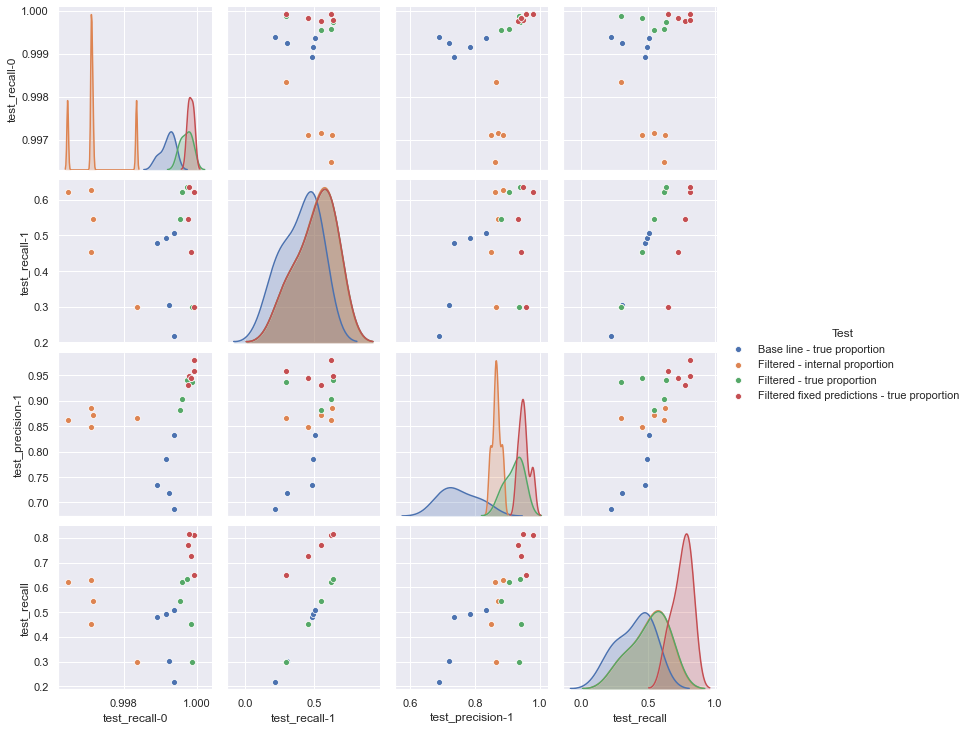

In [28]:
scr_fill_fmt = scr_fill.rename(columns={
    'recall 0': 'test_recall-0',
    'recall 1': 'test_recall-1',
    'precision 1': 'test_precision-1',
    'recall': 'test_recall'
})

scrs = [
    group_shuffle_scr,
    scr_filt,
    scr_out,
    scr_fill_fmt,
]

for i, score in enumerate(scrs):
    scrs[i]['Test'] = titles[i]

tests = pd.concat(scrs, join='inner')[['test_recall-0', 'test_recall-1', 'test_precision-1', 'test_recall', 'Test']]

ax = sns.pairplot(tests, hue='Test')

---
# Final Model Evaluation

### Select best split

In [193]:
scr_filt.sort_values('test_recall', ascending=False)[['test_recall-1', 'test_precision-1']]

,test_recall-1,test_precision-1
3,0.628378,0.885714
1,0.622517,0.862385
2,0.546667,0.872340
4,0.452703,0.848101
0,0.298013,0.865385


In [194]:
selected_split = 3
split = cv_filt[selected_split]

### Optional: Shuffle split

### Filter internal train test samples

In [195]:
t_ind, e_ind = split[0], split[1]
print_cls_cnt(Y_filt, t_ind, e_ind)

xt, xe = X_filt.iloc[t_ind], X_filt.iloc[e_ind]
yt, ye = Y_filt.iloc[t_ind], Y_filt.iloc[e_ind]

,Train set,Test set
Class,,
0.0,16863,4160
1.0,600,148


### Filtered train vs rest sample

In [196]:
train_index = yt.index
test_index = Y.drop(yt.index).index
print_cls_cnt(Y, train_index, test_index)

x_rest, y_rest = Xf.loc[test_index], Y.loc[test_index]

,Train set,Test set
Class,,
0.0,16863,102293
1.0,600,148


### True proportion test sample

In [197]:
from imblearn.under_sampling import RandomUnderSampler

y_cnt = Y.value_counts()
rus = RandomUnderSampler(sampling_strategy=y_cnt[1]/y_cnt[0], random_state=seed)

x_true, y_true = rus.fit_resample(x_rest, y_rest) # resample full test data to true proportion
y_true.index = y_rest.iloc[rus.sample_indices_].index
x_true.index = y_true.index

display(y_true.value_counts().to_frame('Test size - true proportion'))

,Test size - true proportion
0.0,23576
1.0,148


### Sample leaking

In [229]:
train_index.isin(ye.index).sum()

0

In [230]:
train_index.isin(test_index).sum()

0

In [231]:
train_index.isin(x_true.index).sum()

0

In [232]:
train_index.isin(X_eval.index).sum()

0

### Fit model to train data

In [201]:
model = gbc(n_estimators=100, random_state=seed, verbose=1)

model.fit(xt, yt)

      Iter       Train Loss   Remaining Time 
         1           0.2011           46.39s
         2           0.1801           44.16s
         3           0.1657           42.20s
         4           0.1536           40.93s
         5           0.1441           40.60s
         6           0.1351           40.81s
         7           0.1274           39.84s
         8           0.1201           39.83s
         9           0.1145           38.98s
        10           0.1087           38.44s
        20           0.0770           33.53s
        30           0.0633           29.37s
        40           0.0555           25.21s
        50           0.0502           20.94s
        60           0.0461           16.80s
        70           0.0426           12.77s
        80           0.0395            8.56s
        90           0.0366            4.26s
       100           0.0346            0.00s


GradientBoostingClassifier(random_state=0, verbose=1)

### Split internal proportion test set score

In [217]:
yhat = model.predict(xe)
CR = pd.DataFrame(cr(ye, yhat, digits=4, output_dict=True)).T
display(CR.loc[['0.0', '1.0']])

,precision,recall,f1-score,support
0.0,0.986914,0.997115,0.991989,4160.0
1.0,0.885714,0.628378,0.735178,148.0


### True proportion test set score

In [218]:
yhat_true = model.predict(x_true)
CR = pd.DataFrame(cr(y_true, yhat_true, digits=4, output_dict=True)).T
display(CR.loc[['0.0', '1.0']])

,precision,recall,f1-score,support
0.0,0.997672,0.999746,0.998708,23576.0
1.0,0.939394,0.628378,0.753036,148.0


Obs: Test negative sample size is increased but negative precision increases anyway, against what's expected.

### Validation set score

In [227]:
yhat_eval = model.predict(X_eval)
scr = pd.DataFrame(cr(Y_eval, yhat_eval, output_dict=True)).T
display(scr.loc[['0.0', '1.0']])

,precision,recall,f1-score,support
0.0,0.997220,0.996989,0.997104,17269.0
1.0,0.531532,0.551402,0.541284,107.0


### Filled validation set score

In [220]:
# Filter data by positive class minimum values
X_eval_filt = min_max_filter(
    X_eval, min_values, # max_values,
    n_filters=n_filters, margin_min=0.0, margin_max=0.0
)

filt_out = ~ Y_eval.index.isin(X_eval_filt.index)

yhat_fill = yhat_eval.copy()
yhat_fill[filt_out] = 0.0  # Fix prediction for data left out of the filter

scr = pd.DataFrame(cr(Y_eval, yhat_fill, output_dict=True)).T
display(scr.loc[['0.0', '1.0']])


Records: 17376
Records left: 5037
Records left (%): 28.99 %



,precision,recall,f1-score,support
0.0,0.997220,0.997047,0.997133,17269.0
1.0,0.536364,0.551402,0.543779,107.0


---
# Calibration - Risk Threshold Analysis

In [239]:
from sklearn.metrics import precision_recall_curve

yprob = pd.DataFrame(model.predict_proba(x_true), index=y_true.index, columns=['0', '1'])['1']

### Adjust confidence threshold

#### Precision-Recall curve

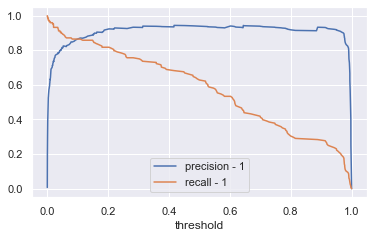


 Classification report for decision threshold of 0.2: 




,precision,recall,f1-score,support
0.0,0.999152,0.999152,0.999152,23576.000000
1.0,0.864865,0.864865,0.864865,148.000000
accuracy,0.998314,0.998314,0.998314,0.998314
macro avg,0.932008,0.932008,0.932008,23724.000000
weighted avg,0.998314,0.998314,0.998314,23724.000000


In [240]:
yhat_fix = (yprob > 0.1).astype('int')

curve = pd.DataFrame(
    precision_recall_curve(y_true, yprob, pos_label=1),
    index=['precision', 'recall', 'threshold']
).T.set_index('threshold').add_suffix(f' - 1')

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
curve.plot(ax=ax); plt.show()
print('\n', 'Classification report for decision threshold of 0.2:', '\n\n')

scr = pd.DataFrame(cr(y_true, yhat_fix, digits=4, output_dict=True)).T
display(scr)

---
# Risk calibration validation test set

In [241]:
yprob_eval = pd.DataFrame(model.predict_proba(X_eval), index=X_eval.index, columns=['0', '1'])['1']

### Adjust confidence threshold

#### Precision-Recall curve

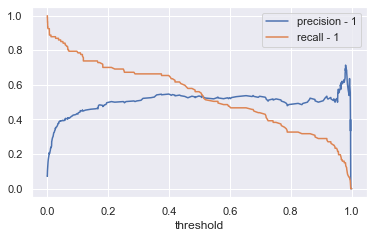


 Classification report for decision threshold of 0.2: 




,precision,recall,f1-score,support
0.0,0.998719,0.993399,0.996052,17269.000000
1.0,0.427136,0.794393,0.555556,107.000000
accuracy,0.992173,0.992173,0.992173,0.992173
macro avg,0.712927,0.893896,0.775804,17376.000000
weighted avg,0.995199,0.992173,0.993339,17376.000000


In [259]:
curve = pd.DataFrame(
    precision_recall_curve(Y_eval, yprob_eval, pos_label=1),
    index=['precision', 'recall', 'threshold']
).T.set_index('threshold').add_suffix(f' - 1')

yhat_fix = (yprob_eval > 0.09).astype('int')

scr = pd.DataFrame(cr(Y_eval, yhat_fix, digits=4, output_dict=True)).T

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
curve.plot(ax=ax); plt.show()

print('\n', 'Classification report for decision threshold of 0.2:', '\n\n')
display(scr)

### Optimal decision threshold

In [260]:
opt_tresh = 0.09

### Calibration curve

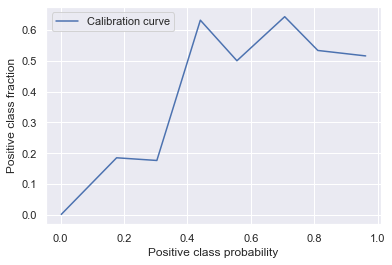

In [261]:
from sklearn.calibration import calibration_curve
cal_curve = calibration_curve(Y_eval, yprob_eval, n_bins=8, strategy='uniform')
calibration = pd.Series(cal_curve[0], index=cal_curve[1]).to_frame('Calibration curve')
ax = calibration.plot()
ax = ax.set(ylabel='Positive class fraction', xlabel='Positive class probability')

### Specific period score

#### Accuracy per month and quarter by 

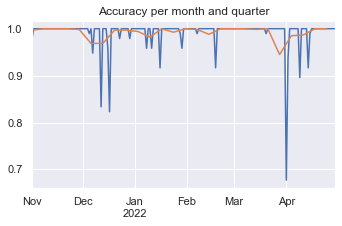

In [262]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3.3), tight_layout=True)
(Y_eval == yhat_fix).resample('D').mean().plot(ax=ax)
(Y_eval == yhat_fix).resample('W').mean().plot(ax=ax)
ax.set(title=f'Accuracy per month and quarter'); plt.show()

### Specific period evaluation

In [249]:
pred_cmap = lambda pred, true_value: 'red' if pred!=true_value else ('green' if true_value==1 else (0,0,0,0))

def prediction_probability_plot(yprob, y, threshold=0.5, start=None, end=None, figsize=(12, 6)):
    
    if start is None: start = y.index.min()
    if end is None: end = y.index.max()
    
    yhat = (yprob > threshold).astype('int')
    
    prob_msk = (yprob.index > start) & (yprob.index < end)
    msk = (y.index > start) & (y.index < end)

    colors = list(map(pred_cmap, yhat[msk], y[msk]))
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    yprob[prob_msk].plot(ax=ax)
    y[msk].plot(ax=ax, color='orange', lw=1, alpha=.75)
    y[msk][y[msk]==1].plot(ax=ax, ms=5, marker='o', color='orange', lw=0)
    ax.scatter(
        yprob.index[prob_msk], yprob[prob_msk], s=30,
        color=colors
    )
    ax.set(title='Test samples predicted class probability')
    plt.show()

<ipython-input-263-13a0bae9a7ec>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start = pd.datetime(2021, 11, 25)
<ipython-input-263-13a0bae9a7ec>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end = pd.datetime(2022, 4, 25)
c:\Users\luisr\anaconda3\lib\site-packages\matplotlib\colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)
c:\Users\luisr\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

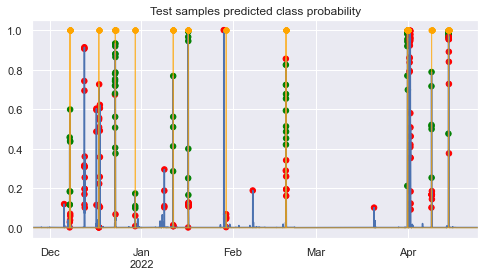

In [263]:
start = pd.datetime(2021, 11, 25)
end = pd.datetime(2022, 4, 25)

prediction_probability_plot(yprob_eval, Y_eval, opt_tresh, start, end, figsize=(8, 4))

<ipython-input-264-924f1a708603>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start = pd.datetime(2021, 12, 7, 16)
<ipython-input-264-924f1a708603>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end = pd.datetime(2021, 12, 8, 1)
c:\Users\luisr\anaconda3\lib\site-packages\matplotlib\colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)
c:\Users\luisr\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

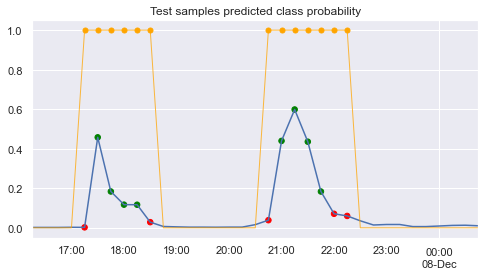

In [264]:
start = pd.datetime(2021, 12, 7, 16)
end = pd.datetime(2021, 12, 8, 1)

prediction_probability_plot(yprob_eval, Y_eval, opt_tresh, start, end, figsize=(8, 4))

<ipython-input-265-924f1a708603>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start = pd.datetime(2021, 12, 7, 16)
<ipython-input-265-924f1a708603>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end = pd.datetime(2021, 12, 8, 1)
c:\Users\luisr\anaconda3\lib\site-packages\matplotlib\colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)
c:\Users\luisr\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

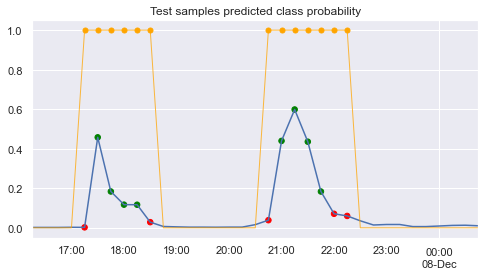

In [265]:
start = pd.datetime(2021, 12, 7, 16)
end = pd.datetime(2021, 12, 8, 1)

prediction_probability_plot(yprob_eval, Y_eval, opt_tresh, start, end, figsize=(8, 4))

<ipython-input-266-e273d4319a1c>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start = pd.datetime(2021, 12, 22, 18)
<ipython-input-266-e273d4319a1c>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end = pd.datetime(2021, 12, 23, 10)
c:\Users\luisr\anaconda3\lib\site-packages\matplotlib\colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)
c:\Users\luisr\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with

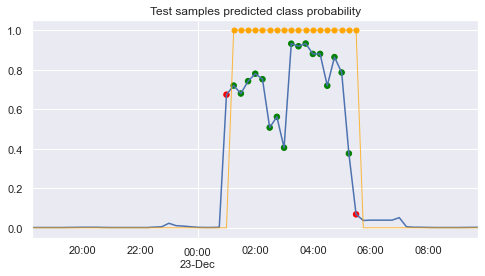

In [266]:
start = pd.datetime(2021, 12, 22, 18)
end = pd.datetime(2021, 12, 23, 10)

prediction_probability_plot(yprob_eval, Y_eval, opt_tresh, start, end, figsize=(8, 4))

<ipython-input-267-62033b9fb0d8>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start = pd.datetime(2021, 12, 29, 18)
<ipython-input-267-62033b9fb0d8>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end = pd.datetime(2021, 12, 30, 4)
c:\Users\luisr\anaconda3\lib\site-packages\matplotlib\colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)
c:\Users\luisr\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with 

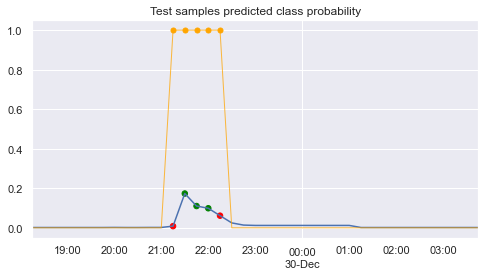

In [267]:
start = pd.datetime(2021, 12, 29, 18)
end = pd.datetime(2021, 12, 30, 4)

prediction_probability_plot(yprob_eval, Y_eval, opt_tresh, start, end, figsize=(8, 4))

<ipython-input-268-f4b3cc4bc84d>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start = pd.datetime(2022, 1, 11, 12)
<ipython-input-268-f4b3cc4bc84d>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end = pd.datetime(2022, 1, 12, 1)
c:\Users\luisr\anaconda3\lib\site-packages\matplotlib\colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)
c:\Users\luisr\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

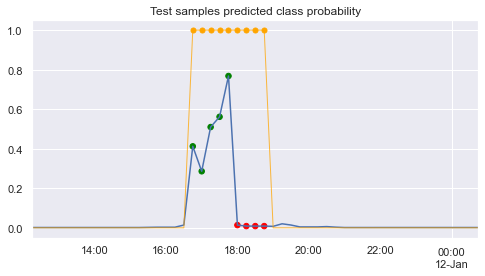

In [268]:
start = pd.datetime(2022, 1, 11, 12)
end = pd.datetime(2022, 1, 12, 1)

prediction_probability_plot(yprob_eval, Y_eval, opt_tresh, start, end, figsize=(8, 4))

<ipython-input-270-04f83ce8cb80>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start = pd.datetime(2022, 1, 16, 14)
<ipython-input-270-04f83ce8cb80>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end = pd.datetime(2022, 1, 17, 1)
c:\Users\luisr\anaconda3\lib\site-packages\matplotlib\colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)
c:\Users\luisr\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

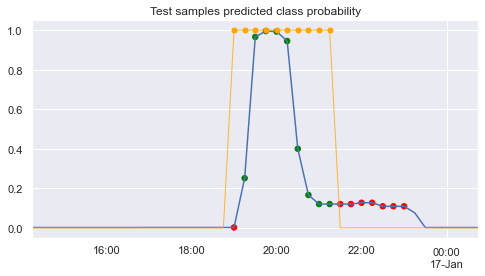

In [270]:
start = pd.datetime(2022, 1, 16, 14)
end = pd.datetime(2022, 1, 17, 1)

prediction_probability_plot(yprob_eval, Y_eval, opt_tresh, start, end, figsize=(8, 4))

<ipython-input-271-8c433bfb4229>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start = pd.datetime(2022, 1, 29, 12)
<ipython-input-271-8c433bfb4229>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end = pd.datetime(2022, 1, 30, 1)
c:\Users\luisr\anaconda3\lib\site-packages\matplotlib\colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)
c:\Users\luisr\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

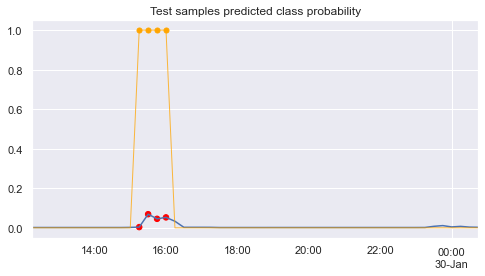

In [271]:
start = pd.datetime(2022, 1, 29, 12)
end = pd.datetime(2022, 1, 30, 1)

prediction_probability_plot(yprob_eval, Y_eval, opt_tresh, start, end, figsize=(8, 4))

<ipython-input-273-8c433bfb4229>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start = pd.datetime(2022, 1, 29, 12)
<ipython-input-273-8c433bfb4229>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end = pd.datetime(2022, 1, 30, 1)
c:\Users\luisr\anaconda3\lib\site-packages\matplotlib\colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)
c:\Users\luisr\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

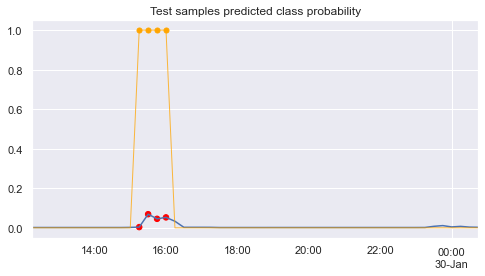

In [273]:
start = pd.datetime(2022, 1, 29, 12)
end = pd.datetime(2022, 1, 30, 1)

prediction_probability_plot(yprob_eval, Y_eval, opt_tresh, start, end, figsize=(8, 4))

# Save model

### Save finalized model

In [314]:
import pickle

pickle.dump(model, open('ModeloBolsõesCatete.pickle', 'wb'))

### Save model deployment transformation info

#### Transformation steps:
0. Reshape apis response to flat format
1. Drop non-included columns (empty excluded columns)
1. Scale all columns based on 'X' sample min and max values
1. Fill missing values with sample min values

In [311]:
# Save Features description
X_info = data.loc[X.index, X.columns].describe().loc[['min', 'max']].T
# X_info.to_csv('InformaçõesDeployCatete.csv', index=True)

# Save train index
# train_index.to_series(name='Train Index').to_csv('TrainIndexCatete.csv', index=False)

display(X_info.head(), X_info.shape, train_index[:5])

,min,max
acumulado_chuva_1_h - A602,0.0,65.0
pressao_minima - A602,999.3,1030.7
temperatura - A602,11.2,38.9
pressao_maxima - A602,999.4,1031.0
pressao - A602,999.3,1030.9


(217, 2)

DatetimeIndex(['2018-10-10 17:30:00', '2018-10-10 17:45:00',
               '2018-10-10 18:00:00', '2018-10-10 18:15:00',
               '2018-10-10 18:30:00'],
              dtype='datetime64[ns]', freq=None)

---
## Next steps:
1. Check posibility of train_size or threshold optimization on internal split
1. Aggregate observations one hour ahead
1. Different undersampling techniques
1. Pieline for all samples
1. Calibration cv


---
# Critical water bag group - Exploratory Data analysis

In [80]:
bins = np.arange(0, 1.01, 0.01)
bins0 = np.arange(0, 1.01, 0.2)

## Average Mean and Median Difference

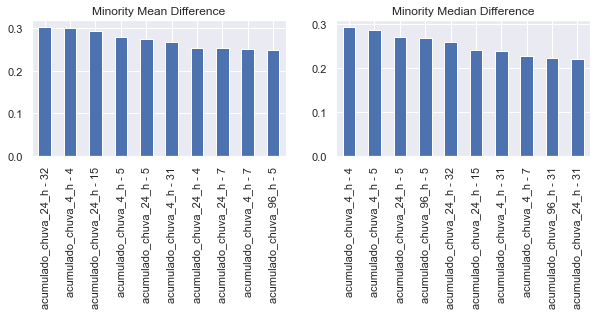

In [81]:
mean_diff = abs(majo.mean() - mino.mean()).sort_values(ascending=False)
median_diff = abs(majo.median() - mino.median()).sort_values(ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(10,2.5))
mean_diff.head(10).plot.bar(ax=ax[0], title='Minority Mean Difference')
median_diff.head(10).plot.bar(ax=ax[1], title='Minority Median Difference')
plt.show()

### Minority/majority percentiles comparison

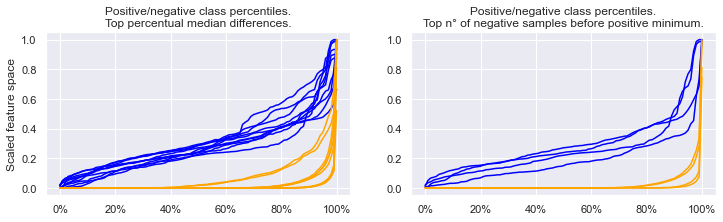

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
mino.loc[:, median_diff.index[:10]].describe(np.arange(0, 1.01, 0.01)).iloc[4:-1].plot(legend=[], color='blue', ax=ax[0])
majo.loc[:, median_diff.index[:10]].describe(np.arange(0, 1.01, 0.01)).iloc[4:-1].plot(legend=[], color='orange', ax=ax[0])

mino.loc[:, stats['column'][:4]].describe(np.arange(0, 1.01, 0.01)).iloc[4:-1].plot(legend=[], color='blue', ax=ax[1])
majo.loc[:, stats['column'][:4]].describe(np.arange(0, 1.01, 0.01)).iloc[4:-1].plot(legend=[], color='orange', ax=ax[1])

ax[0].set(title='Positive/negative class percentiles.\nTop percentual median differences.', ylabel='Scaled feature space')
ax[1].set(title='Positive/negative class percentiles.\nTop n° of negative samples before positive minimum.')
plt.show()

## Incident/no-incident Distributions

#### Minority highest percentual median differences

,Class Count - Y
0.0,122095
1.0,689


,Class Count - Y Sample
0.0,2296
1.0,689


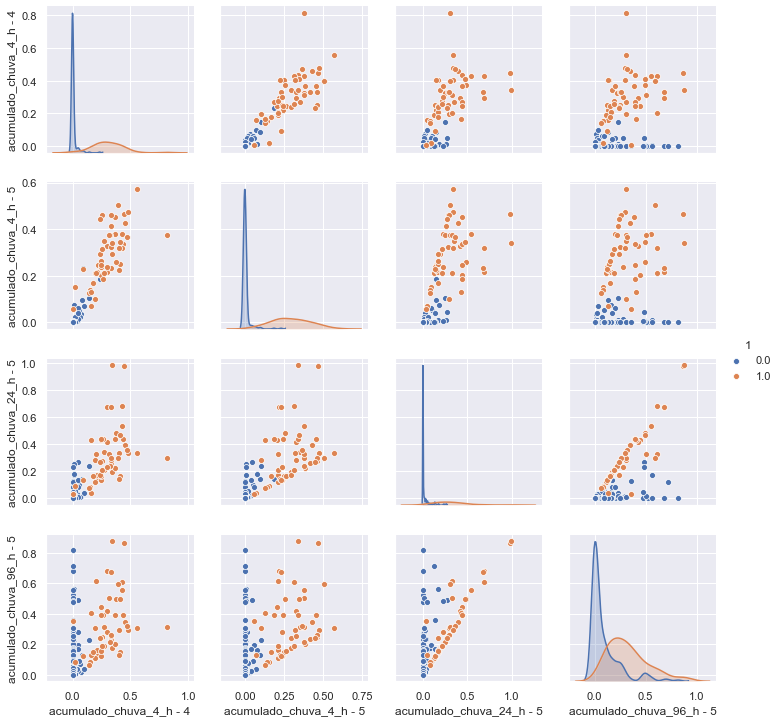

In [83]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=.3, random_state=42)

X_res, Y_res = rus.fit_resample(X, Y)
display(Y.value_counts().to_frame('Class Count - Y'))
display(Y_res.value_counts().to_frame('Class Count - Y Sample'))

ax = sns.pairplot(X_res[median_diff.index[:4]].join(Y_res).sample(250), hue=str(top_grp), kind='scatter', diag_kind='auto')
plt.show()

### Highest minority percentual median difference - After min max filter

,Class Count - Y
0.0,122095
1.0,689


,Class Count - Y Sample
0.0,2296
1.0,689


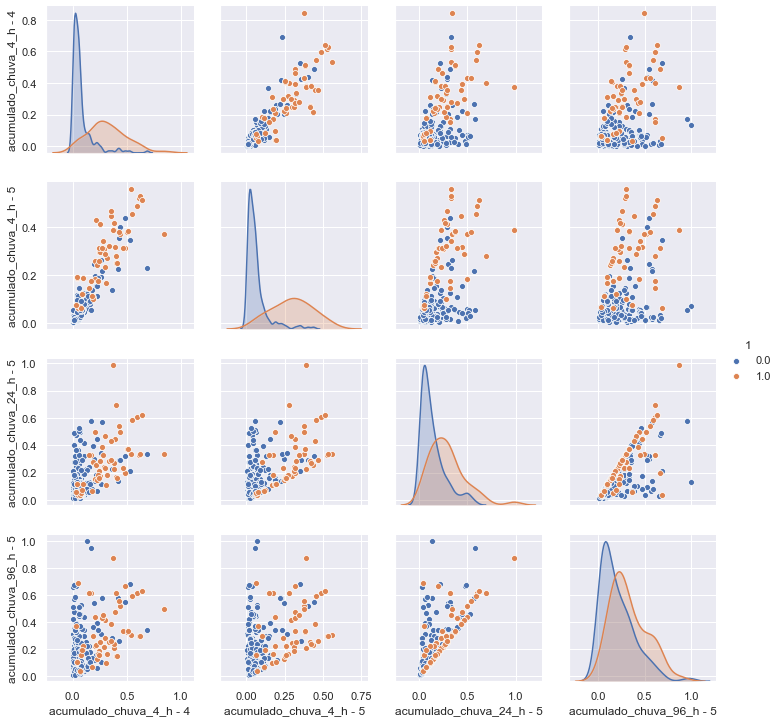

In [84]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=.3, random_state=42)

X_res, Y_res = rus.fit_resample(X_filt, Y_filt)
display(Y.value_counts().to_frame('Class Count - Y'))
display(Y_res.value_counts().to_frame('Class Count - Y Sample'))

ax = sns.pairplot(X_res[median_diff.index[:4]].join(Y_res).sample(250), hue=str(top_grp), kind='scatter', diag_kind='auto')
plt.show()

### Highest number of samples before minority minimum values

,Class Count - Y
0.0,122095
1.0,689


,Class Count - Y Sample
1.0,689
0.0,689


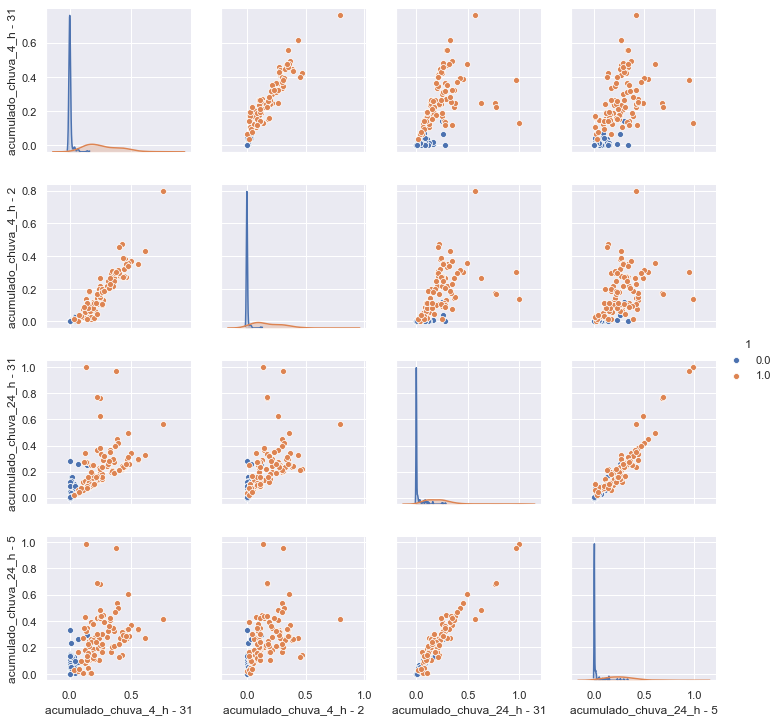

In [85]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=1, random_state=42)

X_res, Y_res = rus.fit_resample(X, Y)
display(Y.value_counts().to_frame('Class Count - Y'))
display(Y_res.value_counts().to_frame('Class Count - Y Sample'))

ax = sns.pairplot(X_res[stats['column'].iloc[:4]].join(Y_res).sample(250), hue=str(top_grp), kind='scatter', diag_kind='auto')
plt.show()

### Highest number of samples before minority minimum values - After min max filter

,Class Count - Y
0.0,122095
1.0,689


,Class Count - Y Sample
1.0,689
0.0,689


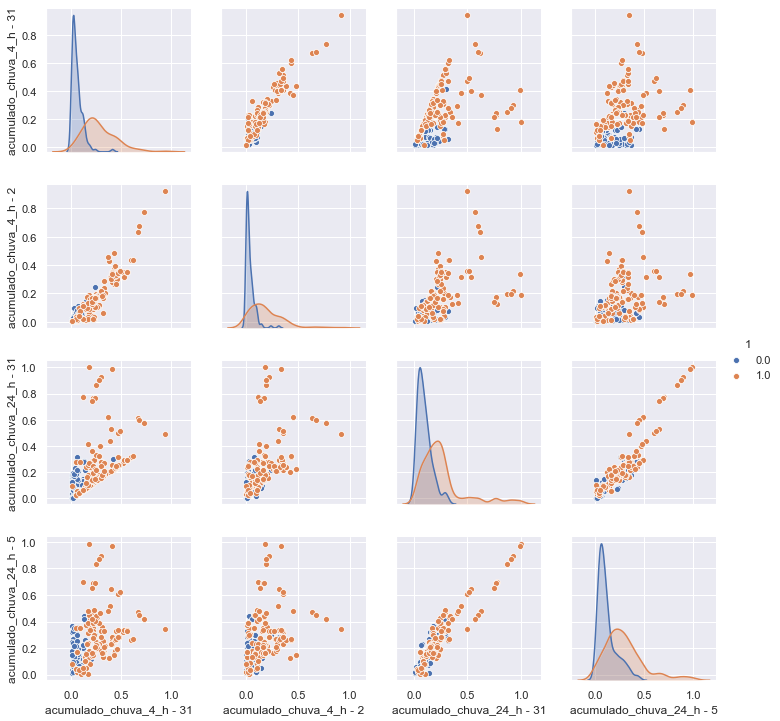

In [86]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=, random_state=42)

X_res, Y_res = rus.fit_resample(X_filt, Y_filt)
display(Y.value_counts().to_frame('Class Count - Y'))
display(Y_res.value_counts().to_frame('Class Count - Y Sample'))

ax = sns.pairplot(X_res[stats['column'].iloc[:4]].join(Y_res).sample(250), hue=str(top_grp), kind='scatter', diag_kind='auto')
plt.show()

### Top median difference feature space

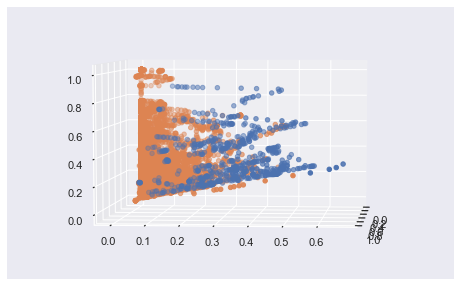

In [92]:
x = median_diff.index[0]
y = median_diff.index[1]
z = median_diff.index[3]

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(mino[x], mino[y], mino[z])
ax.scatter(majo[x], majo[y], majo[z])
ax.view_init(5, 5)